<a href="https://colab.research.google.com/github/Pranav-Kumar14/Stock-Prediction-Model/blob/main/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter stock ticker symbol (e.g., AAPL, TSLA): aapl


[*********************100%***********************]  1 of 1 completed


Random Forest RMSE: 25.62, MAPE: 8.01%


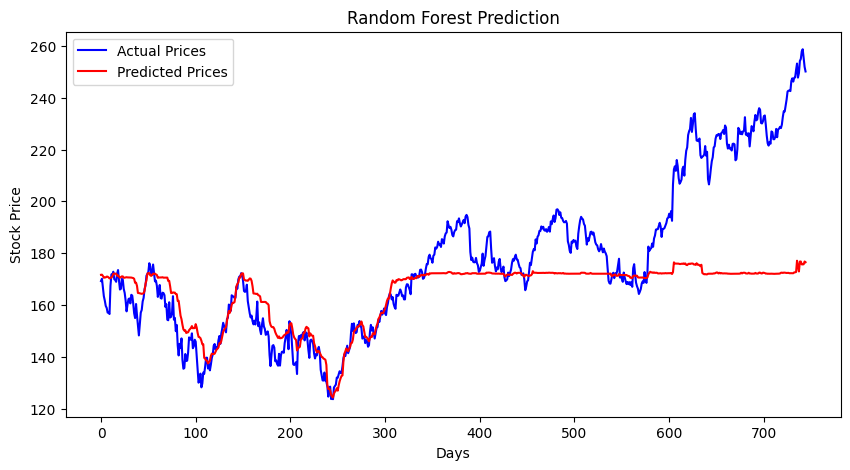

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.5361 - r2_score: -20.7717
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1276 - r2_score: -4.3327
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0756 - r2_score: -2.0785
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0495 - r2_score: -1.0139
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0345 - r2_score: -0.4569
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0238 - r2_score: -0.0029
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0199 - r2_score: 0.1378
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0202 - r2_score: 0.1203
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0120 - r2_score: 0.4659
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0117 - r2_score: 0.4996
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0088 - r2_score: 0.6136
Epoch 12/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - lo

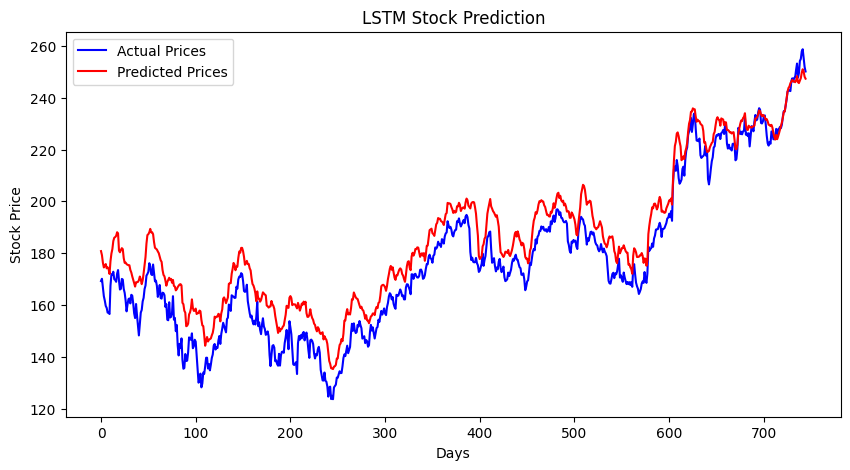

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

def get_stock_data(ticker, start="2010-01-01", end="2025-01-01"):
    stock_data = yf.download(ticker, start=start, end=end)
    return stock_data

def prepare_features(data):
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()
    data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
    data['Volatility'] = data['Close'].rolling(window=10).std()

    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    data['RSI'] = 100 - (100 / (1 + gain / loss))

    data['MACD'] = data['EMA_10'] - data['EMA_50']

    data.dropna(inplace=True)
    return data

def split_data(data):
    features = ['SMA_10', 'SMA_50', 'EMA_10', 'EMA_50', 'Volatility', 'RSI', 'MACD']
    X = data[features]
    y = data['Close']

    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)

    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

    return X_train, X_test, y_train, y_test, scaler_X, scaler_y

def train_random_forest(X_train, y_train):
    rf_model = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
    rf_model.fit(X_train, y_train.ravel())
    return rf_model

def train_lstm(X_train, y_train):
    X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # Reshape for LSTM

    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(X_train_reshaped.shape[1], 1)),
        Dropout(0.3),
        BatchNormalization(),

        LSTM(64, return_sequences=False),
        Dropout(0.3),
        BatchNormalization(),

        Dense(32, activation='relu'),
        Dropout(0.2),

        Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[tf.keras.metrics.R2Score()])
    model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, verbose=1)

    return model

def evaluate_model(model, X_test, y_test, scaler_y, model_type="Random Forest"):
    predictions = model.predict(X_test)
    predictions = scaler_y.inverse_transform(predictions.reshape(-1, 1))
    y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mape = mean_absolute_percentage_error(y_test, predictions)

    print(f"{model_type} RMSE: {rmse:.2f}, MAPE: {mape:.2%}")
    return predictions, y_test

def plot_predictions(actual, predicted, title="Stock Price Prediction"):
    plt.figure(figsize=(10, 5))
    plt.plot(actual, label="Actual Prices", color="blue")
    plt.plot(predicted, label="Predicted Prices", color="red")
    plt.title(title)
    plt.xlabel("Days")

    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    ticker = input("Enter stock ticker symbol (e.g., AAPL, TSLA): ")
    stock_data = get_stock_data(ticker)
    stock_data = prepare_features(stock_data)

    X_train, X_test, y_train, y_test, scaler_X, scaler_y = split_data(stock_data)

    rf_model = train_random_forest(X_train, y_train)
    rf_predictions, y_test_real = evaluate_model(rf_model, X_test, y_test, scaler_y, "Random Forest")
    plot_predictions(y_test_real, rf_predictions, "Random Forest Prediction")

    lstm_model = train_lstm(X_train, y_train)

    X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))  # Reshape for LSTM
    lstm_predictions, _ = evaluate_model(lstm_model, X_test_reshaped, y_test, scaler_y, "LSTM Model")

    plot_predictions(y_test_real, lstm_predictions, "LSTM Stock Prediction")
